## Defining the problem - clearly identifying the problem to be solved
Boston Housing - Regression problem


## Data Collection - gathering necessary data from various sources

Importing the necessary libraries and defining the functions

In [252]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import random
import copy

In [253]:
# functions required

def get_k_fold_cv(k, random_state, X, y):
  kfold = KFold(n_splits = k, shuffle = True, random_state = random_state)
  spl = kfold.split(X)
  return spl

# forward selection to select features
def forward_selection(X_train, y_train, X_test, y_test):
  selected_features = []
  selected_features_list = []
  r2_test_list = []
  all_features = list(X_train.columns)
  remaining_features = list(X_train.columns)
  print(f"All Features: {all_features}")
  p = X.shape[1]
  m0 = np.mean(y)
  result = []
  for k in range(p):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    best_feature = None
    best_model = None
    print(f"K = {k}")
    for feature in remaining_features:
      print(f"current feature: {feature}")
      temp_features.append(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      print(f"Best R-Squared and R-Squared-train after adding current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        best_feature = feature
        best_model = model
      temp_features.remove(feature)
      print(f"Current best feature: {best_feature}")
    selected_features.append(best_feature)
    print(f"Selected features: {selected_features}")
    remaining_features.remove(best_feature)
    print(f"Remaining features: {remaining_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)
    result_k = [best_model, r2_test]
    result.append(result_k)
  return result


def mixed_selection(X_train, y_train, X_test, y_test):
  selected_features = []
  selected_features_list = []
  r2_test_list = []
  all_features = list(X_train.columns)
  remaining_features = list(X_train.columns)
  print(f"All Features: {all_features}")
  p = X.shape[1]
  m0 = np.mean(y)
  result = []
  for k in range(p):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    best_feature = None
    best_model = None
    print(f"K = {k}")
    for feature in remaining_features:
      print(f"current feature: {feature}")
      temp_features.append(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      print(f"Best R-Squared and R-Squared-train after adding current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        best_feature = feature
        best_model = model
      temp_features.remove(feature)
      print(f"Current best feature: {best_feature}")
    selected_features.append(best_feature)
    print(f"Selected features: {selected_features}")
    remaining_features.remove(best_feature)
    print(f"Remaining features: {remaining_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)

    if k > 1:
      current_selected_features = selected_features.copy()
      best_r2_test_subset = float('-inf')
      temp_features1 = current_selected_features
      removed_features = []
      selected_features_length = len(selected_features)
      for k1 in range(selected_features_length):
        print(f"Selected features length: {len(selected_features)}")
        print(f"Value of K1: {k1}")
        print(f"Best model features: {best_model.model.exog_names}")
        removed_feature = selected_features[k1]
        print(f"removed feature: {removed_feature}")
        temp_features1 = [feature for feature in current_selected_features if feature != removed_feature]
        print(f"Temp features in backward selection: {temp_features1}")
        X_train_subset = X_train.loc[:, temp_features1]
        X_train_subset = sm.add_constant(X_train_subset)
        model = sm.OLS(y_train, X_train_subset).fit()

        X_test_subset = X_test.loc[:, temp_features1]
        X_test_subset = sm.add_constant(X_test_subset)
        y_pred = model.predict(X_test_subset)
        r2_test_subset = r2_score(y_test, y_pred)

        if r2_test_subset > r2_test:
          print("r2_Test_subset > r2_test")
          print(f"Feature removed from selected features: {removed_feature}")
          current_selected_features.remove(removed_feature)
          print(f"Selected features after removal: {current_selected_features}")
          better_subset_exists = True

        temp_features1 = current_selected_features
      selected_features = current_selected_features

  print(f"Final selected features after all the hard work: {selected_features}")
  X_train_subset = X_train.loc[:, selected_features]
  X_train_subset = sm.add_constant(X_train_subset)
  model = sm.OLS(y_train, X_train_subset).fit()

  X_test_subset = X_test.loc[:, selected_features]
  X_test_subset = sm.add_constant(X_test_subset)
  y_pred = model.predict(X_test_subset)
  r2_test = r2_score(y_test, y_pred)
  return (model, r2_test)

# backward selection to select features
def backward_selection(X_train, y_train, X_test, y_test):
  selected_features = list(X_train.columns)
  all_features = list(X_train.columns)
  print(f"All Features: {all_features}")
  p = X_train.shape[1]
  result = []
  for k in range(p, 1, -1):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    worst_feature = None
    best_model = None
    print(f"K = {k}")
    for feature in selected_features:
      print(f"current feature: {feature}")
      temp_features.remove(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      print(f"Best R-Squared and R-Squared-train after removing current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        worst_feature = feature
        best_model = model
      temp_features.append(feature)
      print(f"Current worst feature: {worst_feature}")
    selected_features.remove(worst_feature)
    print(f"Selected features: {selected_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    print(f"X_test_subset columns: {X_test_subset.columns}")
    print(f"Best model details: {best_model.model.exog_names}, {best_model.rsquared}")
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)
    print(f"R-squared Test: {r2_test}")
    result_k = [best_model, r2_test]
    result.append(result_k)
  return result

## Data Cleaning and pre-processing

In [254]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
          'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("housing.csv", delim_whitespace=True, names = columns)
df.head(10)

/tmp/ipython-input-810203818.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("housing.csv", delim_whitespace=True, names = columns)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [255]:
target = 'MEDV'
features = [x for x in columns if x != target]

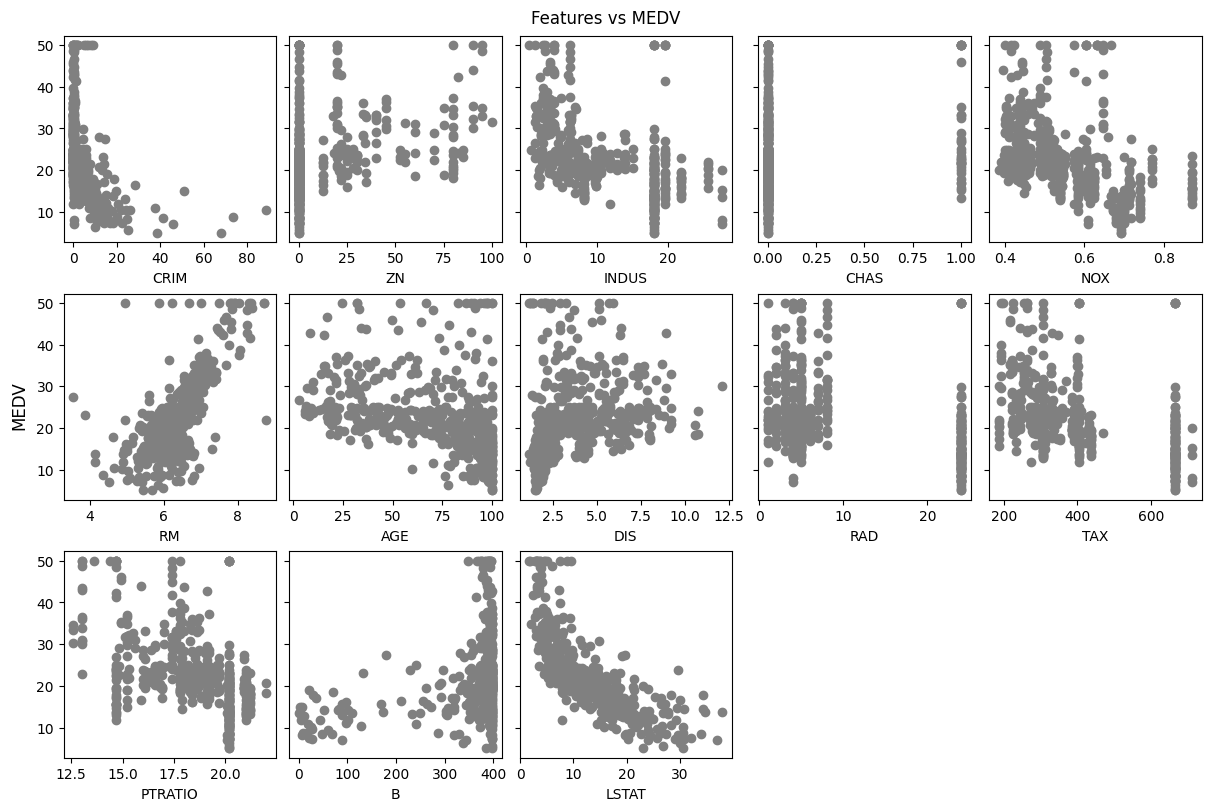

In [256]:
cols = 5
rows = 3
k = 0
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 8), layout = 'constrained', sharey = True)
for i in range(rows):
  for j in range(cols):
    if(k < len(features)):
      ax[i, j].scatter(df[features[k]], df[target], c = 'grey')
      ax[i, j].set_xlabel(features[k])
      k+=1
ax[2, 3].remove()
ax[2, 4].remove()
fig.supylabel(target)
fig.suptitle(f'Features vs {target}')
plt.show()

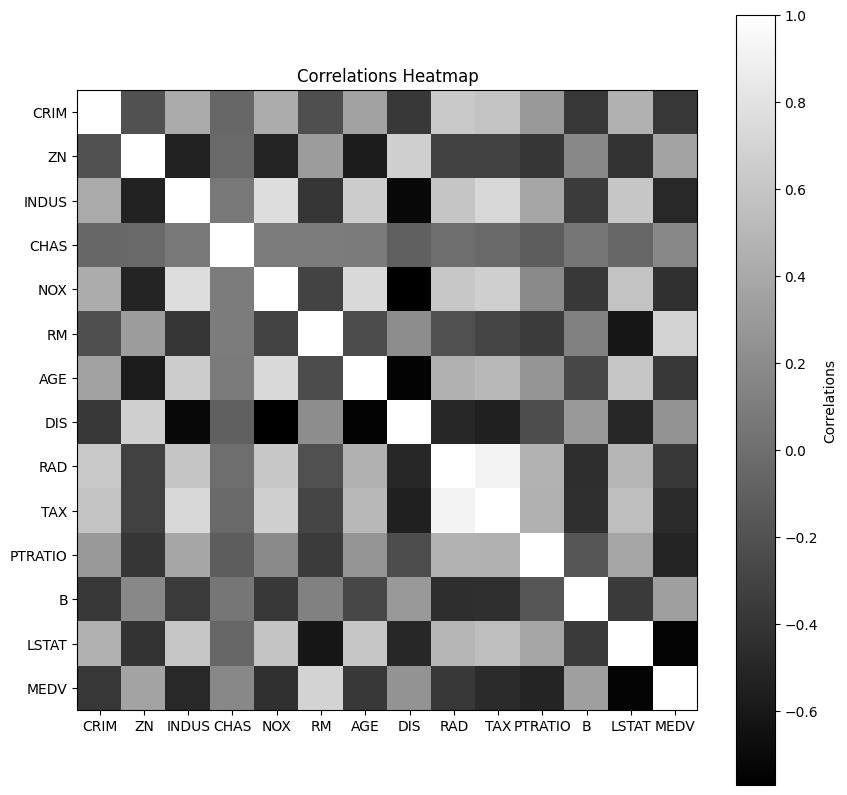

In [257]:
correlations = df.corr()
fig, ax = plt.subplots(figsize = (10, 10))
img = ax.imshow(correlations, cmap = 'grey')
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns)
ax.figure.colorbar(img, label = 'Correlations', ax = ax)
plt.title('Correlations Heatmap')
plt.show()

In [258]:
print(f"Data Summary: \n{df.describe()}\n")
print(f"Data Shape: \n{df.shape}")

Data Summary: 
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.1

### EDA - Exploratory Data Analysis - Analysing data to identify patterns, outliers

In [259]:
# coefficient of variation for different features - a relative measurement of dispersion
cv = (df.std() / df.mean()) * 100
print(cv)

CRIM       238.037610
ZN         205.237586
INDUS       61.600874
CHAS       367.202814
NOX         20.890339
RM          11.179921
AGE         41.048344
DIS         55.485809
RAD         91.181152
TAX         41.284120
PTRATIO     11.730604
B           25.596162
LSTAT       56.437413
MEDV        40.816505
dtype: float64


Univariate Analysis

Number of bins: 22


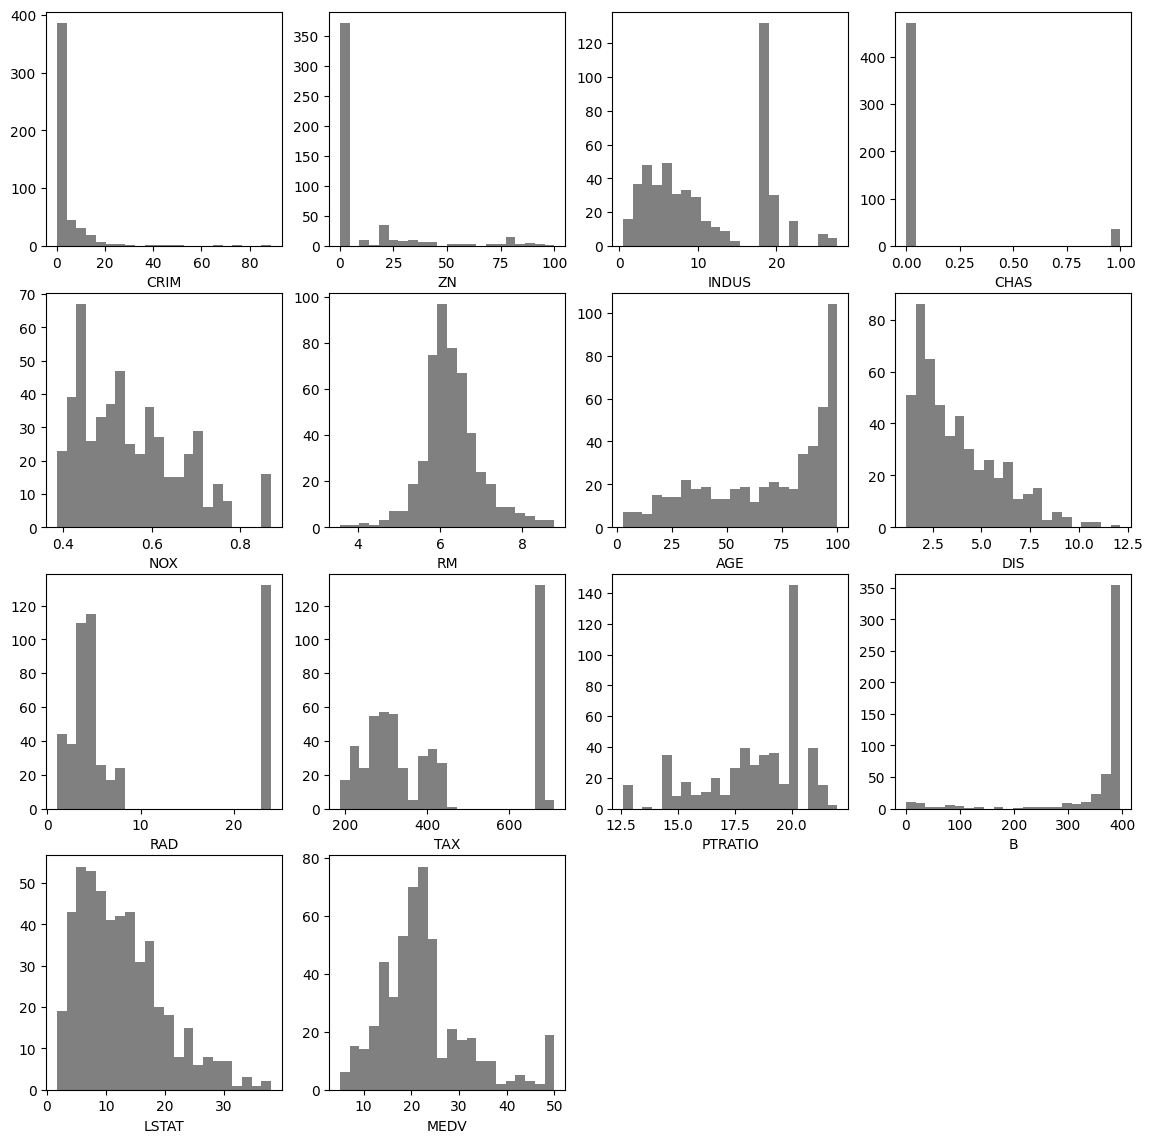

In [260]:
number_of_bins = round(np.sqrt(df.shape[0]))
print(f"Number of bins: {number_of_bins}")
plt.figure(figsize = (14, 14))
i = 1
for column in df.columns:
  plt.subplot(4, 4, i)
  plt.hist(df[column], bins = number_of_bins, color = 'grey')
  plt.xlabel(column)
  i+=1
plt.show()

## regressor1 = model with all the features

In [261]:
def get_single_split(df, test_size = 0.1, random_state = 42):
  df_train_cv, df_test = train_test_split(df, test_size = 0.1, random_state = 42)
  print(f"Train-Validation dataset shape: {df_train_cv.shape}")
  print(f"Test dataset shape: {df_test.shape}")
  X_test, y_test = df_test.loc[:, features], df_test.loc[:, target]
  print(f"No. of features in Test dataset: {X_test.shape}")
  print(f"Target length in Test dataset: {y_test.shape}")

  df_train, df_cv = train_test_split(df_train_cv, test_size = 0.1, random_state = 42)
  X_train, X_cv, y_train, y_cv = df_train.loc[:, df.columns != 'MEDV'], df_cv.loc[:, df.columns != 'MEDV'], df_train['MEDV'], df_cv['MEDV']
  print(f'Data shapes Train and CV: {X_train.shape} {X_cv.shape} {y_train.shape} {y_cv.shape}')
  return X_train, X_cv, X_test, y_train, y_cv, y_test

X_train, X_cv, X_test, y_train, y_cv, y_test = get_single_split(df, test_size = 0.1, random_state = 42)

Train-Validation dataset shape: (455, 14)
Test dataset shape: (51, 14)
No. of features in Test dataset: (51, 13)
Target length in Test dataset: (51,)
Data shapes Train and CV: (409, 13) (46, 13) (409,) (46,)


In [262]:
# def fit_regression_model_ols_and_get_test_r2(train_index, cv_index, X, y):
#   X_train, X_cv = X.iloc[train_index, :], X.iloc[cv_index, :]
#   y_train, y_cv = y.iloc[train_index], y.iloc[cv_index]
#   regressor = sm.OLS(y_train, X_train).fit()
#   y_pred = regressor.predict(X_cv)
#   y_pred_train = regressor.predict(X_train)
#   return regressor, mean_squared_error(y_cv, y_pred), mean_squared_error(y_train, y_pred_train)

In [263]:
# y = df_train_cv['MEDV']
# X = df_train_cv.loc[: , df.columns != 'MEDV']
# X = sm.add_constant(X)
# cv_r2 = []
# train_r2 = []
# number_of_folds = 5
# random_state = 42
# regressor1_models = []
# spl = get_k_fold_cv(number_of_folds, random_state, X, y)
# for i, (train_index, cv_index) in enumerate(spl):
#   print(f"Fold: {i}")
#   model, cv_r2_fold_i, train_r2_fold_i = fit_regression_model_ols_and_get_test_r2(train_index, cv_index, X, y)
#   print(f"CV R2-squared for fold {i}: {cv_r2_fold_i}")
#   print(f"Train R2-squared for fold {i}: {train_r2_fold_i}")
#   cv_r2.append(cv_r2_fold_i)
#   train_r2.append(train_r2_fold_i)
#   regressor1_models.append(model)
# mean_cv_r2 = np.mean(cv_r2)
# mean_train_r2 = np.mean(train_r2)
# print(f"Mean CV R-Squared from {number_of_folds} folds: {mean_cv_r2}")
# print(f"Mean train R-Squared from {number_of_folds} folds: {mean_train_r2}")

In [264]:
regressor1 = sm.OLS(y_train, X_train).fit()
y_pred_cv = regressor1.predict(X_cv)
y_pred_train = regressor1.predict(X_train)
mse_cv = mean_squared_error(y_cv, y_pred_cv)/2
mse_train = mean_squared_error(y_train, y_pred_train)/2
print(f'MSE Train, MSE CV: {mse_train}, {mse_cv}')

MSE Train, MSE CV: 13.014119313505168, 9.044955728432011


In [265]:
print(regressor1.summary())

                                 OLS Regression Results                                
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              665.8
Date:                Mon, 20 Oct 2025   Prob (F-statistic):                   1.06e-259
Time:                        11:08:08   Log-Likelihood:                         -1246.8
No. Observations:                 409   AIC:                                      2520.
Df Residuals:                     396   BIC:                                      2572.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [266]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [267]:
class LinearRegressionImpl:
  def compute_cost(self, X, y, w, b, lambda_ = 0):
    m, n = len(X), len(X[0])
    cost = 0.
    for i in range(m):
      f_wb_i = np.dot(X[i], w) + b
      cost += (f_wb_i - y[i]) ** 2
    cost /= (2 * m)
    return cost

  def compute_gradient(self, X, y, w, b, lambda_ = 0):
    m, n = len(X), len(X[0])
    dj_dw = np.zeros((n,))
    dj_db = 0.
    for i in range(m):
      f_wb_i = np.dot(w, X[i]) + b
      error = (f_wb_i - y[i])
      for j in range(n):
        dj_dw[j] += error * X[i][j]
      dj_db += error
    dj_dw /= m
    dj_db /= m
    for j in range(n):
      dj_dw[j] += (lambda_ / m ) * w[j]
    return dj_dw, dj_db

  def gradient_descent(self, X, y, w_init, b_init, alpha, num_iters, lambda_ = 0):
    cost_history = []
    cost_iters = []
    w = copy.deepcopy(w_init)
    b = b_init
    for i in range(num_iters):
      dj_dw, dj_db = self.compute_gradient(X, y, w, b, lambda_)
      w = w - alpha * dj_dw
      b = b - alpha * dj_db
      if(i % (num_iters/10) == 0):
        cost = self.compute_cost(X, y, w, b)
        cost_history.append(cost)
        cost_iters.append(i+1)
        print(f"Cost for iteration: {i+1}: {cost}")
    return cost_history, cost_iters, w, b

In [268]:
def verify_linear_regression_impl(X, y, learning_rate, lambda_, iterations):
  w_init = np.zeros(X.shape[1])
  b_init = 0
  regressor_impl = LinearRegressionImpl()
  cost_history, cost_iters, w_final, b_final = regressor_impl.gradient_descent(X, y, w_init, b_init, learning_rate, iterations, lambda_)
  print(f"w_final: {w_final}, b_final: {b_final}")
  return cost_history, cost_iters, w_final, b_final

def verify_regression_without_regularization(X, y):
  alpha_ = 0.02
  iterations = 1000
  lambda_ = 0
  return verify_linear_regression_impl(X, y, alpha_, lambda_, iterations)

cost_history, cost_iters, w_final, b_final = verify_regression_without_regularization(np.array(X_train_scaled), np.array(y_train))


Cost for iteration: 1: 282.87621942325654
Cost for iteration: 101: 16.93397737760722
Cost for iteration: 201: 12.134795059491374
Cost for iteration: 301: 11.8451332274944
Cost for iteration: 401: 11.732167537156066
Cost for iteration: 501: 11.66888757575305
Cost for iteration: 601: 11.630667919844335
Cost for iteration: 701: 11.606182400493937
Cost for iteration: 801: 11.589646124521485
Cost for iteration: 901: 11.577971053731638
w_final: [-1.01302725  0.95689498 -0.09139769  0.6960646  -1.95628848  2.44892801
  0.16062237 -3.07217041  1.94374684 -1.14393508 -2.27755508  0.95639179
 -4.04778345], b_final: 22.530806808047156


Text(0, 0.5, 'Cost')

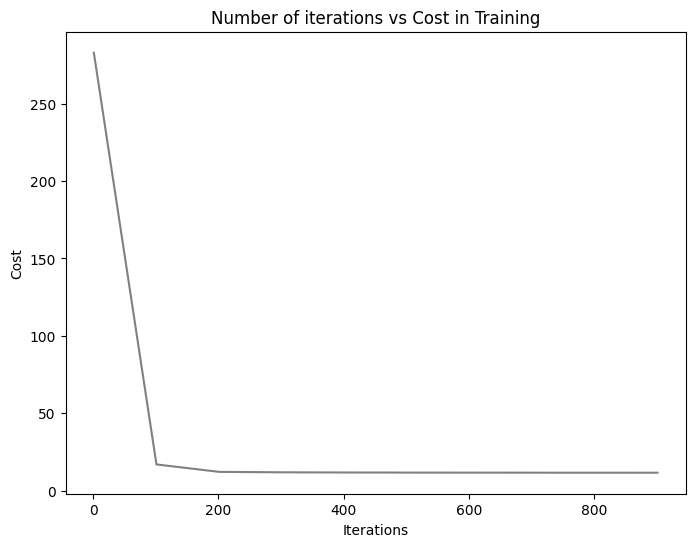

In [269]:
plt.figure(figsize = (8, 6))
plt.plot(cost_iters, cost_history, c = 'grey')
plt.title('Number of iterations vs Cost in Training')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [270]:
X_cv_scaled = scaler.transform(X_cv)
y_hat = np.dot(X_cv_scaled, w_final) + b_final
y_hat_train = np.dot(X_train_scaled, w_final) + b_final
print(f'MSE Train and CV data: {mean_squared_error(y_train, y_hat_train)/2}, {mean_squared_error(y_cv, y_hat)/2}')

MSE Train and CV data: 11.569509266378343, 10.653856928801591


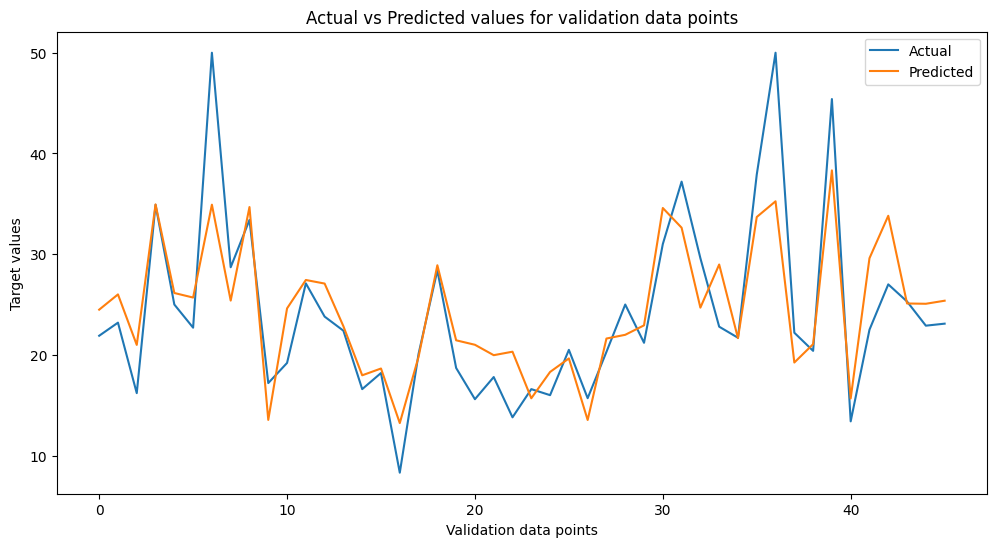

In [271]:
plt.figure(figsize = (12, 6))
plt.plot(range(len(y_cv)), y_cv, label = 'Actual')
plt.plot(range(len(y_cv)), y_hat, label = 'Predicted')
plt.xlabel('Validation data points')
plt.ylabel('Target values')
plt.title('Actual vs Predicted values for validation data points')
plt.legend()
plt.show()

In [272]:
def verify_regression_with_regularization(X, y, lambda_ = 0):
  alpha_ = 0.02
  iterations = 1000
  return verify_linear_regression_impl(X, y, alpha_, lambda_, iterations)

lambdas_ = [0.1, 5, 500, 5000]
lambdas_results = []
mse_cv_lambdas = []
mse_train_lambdas = []
y_pred_cv_lambdas = []
for i in range(len(lambdas_)):
  print(f"Lambda value: {lambdas_[i]}")
  cost_history1, cost_iters1, w_final1, b_final1 = verify_regression_with_regularization(np.array(X_train_scaled), np.array(y_train), lambda_ = lambdas_[i])
  lambdas_results.append((cost_history1, cost_iters1, w_final1, b_final1))
  y_pred_lambda = np.dot(X_cv_scaled, w_final1) + b_final1
  y_pred_cv_lambdas.append(y_pred_lambda)
  mse_cv_lambdas.append(mean_squared_error(y_cv, y_pred_lambda)/2)
  y_pred_train_lambda = np.dot(X_train_scaled, w_final1) + b_final1
  mse_train_lambdas.append(mean_squared_error(y_train, y_pred_train_lambda)/2)

Lambda value: 0.1
Cost for iteration: 1: 282.87621942325654
Cost for iteration: 101: 16.934517693384926
Cost for iteration: 201: 12.13524517447216
Cost for iteration: 301: 11.845622627051322
Cost for iteration: 401: 11.732674098214643
Cost for iteration: 501: 11.669381896326325
Cost for iteration: 601: 11.631134082515516
Cost for iteration: 701: 11.606615075989382
Cost for iteration: 801: 11.590045733062347
Cost for iteration: 901: 11.57834039406777
w_final: [-1.01236202  0.95575847 -0.09223838  0.69629454 -1.95350125  2.44968504
  0.15992786 -3.06901882  1.94024107 -1.14177189 -2.27665975  0.95626541
 -4.04608154], b_final: 22.530806808047156
Lambda value: 5
Cost for iteration: 1: 282.87621942325654
Cost for iteration: 101: 16.96154925410842
Cost for iteration: 201: 12.158548406773729
Cost for iteration: 301: 11.871274463042361
Cost for iteration: 401: 11.759660798889817
Cost for iteration: 501: 11.696381591591189
Cost for iteration: 601: 11.657441224522115
Cost for iteration: 701: 11

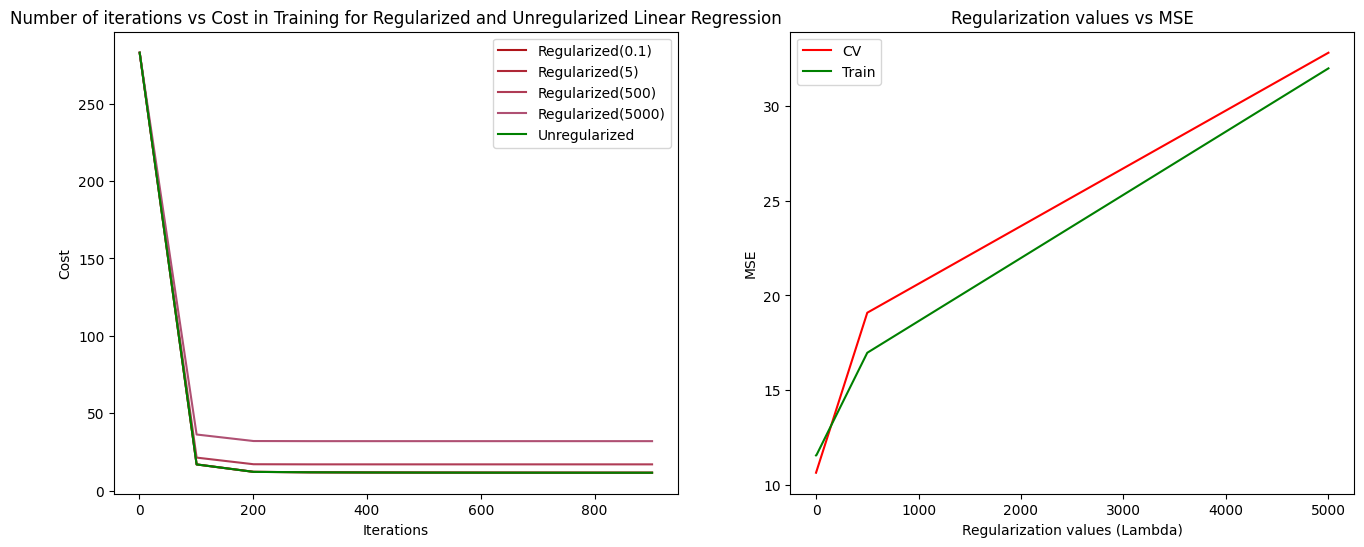

In [273]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
r, g, b = 175./255., 20./255., 25./255.
g_plus, b_plus = 20./255., 30./255.
for i in range(len(lambdas_)):
  ax[0].plot(lambdas_results[i][1], lambdas_results[i][0], c = (r, g, b), label = f'Regularized({lambdas_[i]})')
  g += g_plus
  b += b_plus
  if(g > 1):
    g -= 1
  if(b > 1):
    b-=1
ax[0].plot(cost_iters, cost_history, c = 'green', label = 'Unregularized')
ax[0].set_title('Number of iterations vs Cost in Training for Regularized and Unregularized Linear Regression')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Cost')
ax[0].legend()

ax[1].plot(lambdas_, mse_cv_lambdas, c = 'red', label = 'CV')
ax[1].plot(lambdas_, mse_train_lambdas, c = 'green', label = 'Train')
ax[1].set_title('Regularization values vs MSE')
ax[1].set_xlabel('Regularization values (Lambda)')
ax[1].set_ylabel('MSE')
ax[1].legend()
plt.show()

In [274]:
for i in range(len(lambdas_)):
  print(f'MSE Train and CV data with regularization parameter = {lambdas_[i]}: {mse_train_lambdas[i]}, {mse_cv_lambdas[i]}')

MSE Train and CV data with regularization parameter = 0.1: 11.569851912676882, 10.65539886601963
MSE Train and CV data with regularization parameter = 5: 11.592781599749694, 10.737115666239635
MSE Train and CV data with regularization parameter = 500: 16.980018456143956, 19.091094374177004
MSE Train and CV data with regularization parameter = 5000: 31.97382769833047, 32.79895397832312


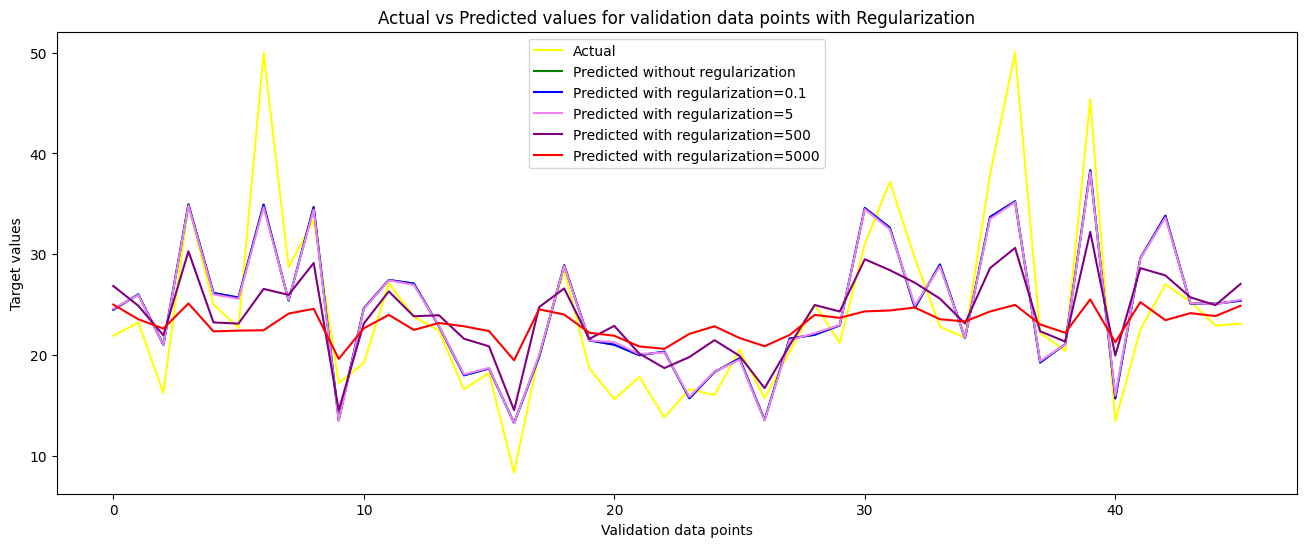

In [275]:
colors = ['blue', 'violet', 'purple', 'red']
plt.figure(figsize = (16, 6))
plt.plot(range(len(y_cv)), y_cv, c = 'yellow', label = 'Actual')
plt.plot(range(len(y_cv)), y_hat, c = 'green', label = 'Predicted without regularization')
for i in range(len(lambdas_)):
  plt.plot(range(len(y_cv)), y_pred_cv_lambdas[i], c = colors[i], label = f'Predicted with regularization={lambdas_[i]}')
plt.xlabel('Validation data points')
plt.ylabel('Target values')
plt.title('Actual vs Predicted values for validation data points with Regularization')
plt.legend()
plt.show()

In [276]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = np.dot(X_test_scaled, w_final) + b_final
print(f'MSE Test data: {mean_squared_error(y_test, y_test_pred)/2}')

MSE Test data: 7.33504761165494


## Including Polynomial Features to have a better fit

In [277]:
poly_2 = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly_2 = poly_2.fit_transform(X_train)
print(f"X_poly shape: {X_train_poly_2.shape}")
print(f"No. of features: {poly_2.n_features_in_}")
print(f"Name of features: {poly_2.feature_names_in_}")
print(f"No. of output features: {poly_2.n_output_features_}")
print(f"Name of output features: {poly_2.get_feature_names_out()}")
scaler_poly_2 = StandardScaler()
X_train_poly_scaled_2 = scaler_poly_2.fit_transform(X_train_poly_2)

X_poly shape: (409, 104)
No. of features: 13
Name of features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
No. of output features: 104
Name of output features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'CRIM^2' 'CRIM ZN' 'CRIM INDUS' 'CRIM CHAS' 'CRIM NOX'
 'CRIM RM' 'CRIM AGE' 'CRIM DIS' 'CRIM RAD' 'CRIM TAX' 'CRIM PTRATIO'
 'CRIM B' 'CRIM LSTAT' 'ZN^2' 'ZN INDUS' 'ZN CHAS' 'ZN NOX' 'ZN RM'
 'ZN AGE' 'ZN DIS' 'ZN RAD' 'ZN TAX' 'ZN PTRATIO' 'ZN B' 'ZN LSTAT'
 'INDUS^2' 'INDUS CHAS' 'INDUS NOX' 'INDUS RM' 'INDUS AGE' 'INDUS DIS'
 'INDUS RAD' 'INDUS TAX' 'INDUS PTRATIO' 'INDUS B' 'INDUS LSTAT' 'CHAS^2'
 'CHAS NOX' 'CHAS RM' 'CHAS AGE' 'CHAS DIS' 'CHAS RAD' 'CHAS TAX'
 'CHAS PTRATIO' 'CHAS B' 'CHAS LSTAT' 'NOX^2' 'NOX RM' 'NOX AGE' 'NOX DIS'
 'NOX RAD' 'NOX TAX' 'NOX PTRATIO' 'NOX B' 'NOX LSTAT' 'RM^2' 'RM AGE'
 'RM DIS' 'RM RAD' 'RM TAX' 'RM PTRATIO' 'RM B' 'RM LSTAT' 'AGE^2'
 'AGE DIS' 'AGE RAD' 'AGE 

In [278]:
cost_history_poly_2, cost_iters_poly_2, w_final_poly_2, b_final_poly_2 = verify_regression_without_regularization(np.array(X_train_poly_scaled_2), np.array(y_train))

Cost for iteration: 1: 269.05476666714515
Cost for iteration: 101: 13.617724629448789
Cost for iteration: 201: 8.330014750931836
Cost for iteration: 301: 7.565640170151941
Cost for iteration: 401: 7.044325991790921
Cost for iteration: 501: 6.632062438162714
Cost for iteration: 601: 6.29849176282668
Cost for iteration: 701: 6.025612706029843
Cost for iteration: 801: 5.800642387753589
Cost for iteration: 901: 5.613916942663843
w_final: [ 0.087814   -0.24945217  0.64146991  0.32988871 -0.04674672  1.44999865
  0.31254348 -0.81859406  1.13672055  0.21214548 -0.18224188  0.11064514
 -0.37412187  0.55257216  0.83259057  0.08115704  2.87899666 -0.24765599
 -0.88511094  0.13887183 -0.49191969 -0.17111466 -0.05013905  0.02154393
 -0.57027893  0.11083031  0.52091143 -0.69450468  0.08462348 -0.02006132
  0.58623831 -0.08043442 -0.15573786 -0.29113373  0.18061493  0.47841429
 -0.21054684 -0.51570174  0.82995842 -0.14078479  0.30283309 -0.86013963
  0.59382278 -1.11542514  0.60706676  0.64269642  0

In [279]:
X_cv_poly_2 = poly_2.transform(X_cv)
X_cv_poly_scaled_2 = scaler_poly_2.transform(X_cv_poly_2)
y_hat_poly_2 = np.dot(X_cv_poly_scaled_2, w_final_poly_2) + b_final_poly_2
y_hat_train_poly_2 = np.dot(X_train_poly_scaled_2, w_final_poly_2) + b_final_poly_2
print(f'MSE Train and CV data: {mean_squared_error(y_train, y_hat_train_poly_2)/2}, {mean_squared_error(y_cv, y_hat_poly_2)/2}')

MSE Train and CV data: 5.459356410447327, 10.648799983876177


In [280]:
raise Exception("Stop! Work under progress!!!")
number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)

def forward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  avg_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
    result = forward_selection(X_train, y_train, X_test, y_test)
    all_fold_result.append(result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds
  print(avg_r2_test)

  return (all_fold_result, avg_r2_test)

all_fold_result, avg_r2_test = forward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state)

Exception: Stop! Work under progress!!!

In [ ]:
def plot_forward_selection_cv_result(avg_r2_test):
  plt.figure(figsize = (5, 4))
  plt.plot(range(1, len(avg_r2_test) + 1), avg_r2_test, marker = 'o')
  plt.xlabel('Degrees of freedom')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with K degrees of freedom and their test scores')
  plt.grid(True)
  plt.show()

plot_forward_selection_cv_result(avg_r2_test)

In [ ]:
for i in range(len(all_fold_result)):
  print(all_fold_result[i][10][0].model.exog_names)
  print(all_fold_result[i][10][1])

In [ ]:
sum_r2_test_11 = 0
avg_r2_test_11 = avg_r2_test[10]
for i in range(len(all_fold_result)):
  sum_r2_test_11 += ((all_fold_result[i][10][1] - avg_r2_test_11) ** 2)
variance_r2_test_11 = sum_r2_test_11 / (number_of_folds-1)
standard_error_r2_test_11 = ((variance_r2_test_11 / (number_of_folds)) ** (1/2))
interval = [avg_r2_test_11 - standard_error_r2_test_11, avg_r2_test_11]
print(avg_r2_test)
print(interval)

Model of size 7 is the smallest sized model that has avg test r-squared of 0.6992152826715315 which falls under one-standard-error interval: [0.6954887804611345, 0.7198685765335143]

In [ ]:
size_7_models = []
for i in range(len(all_fold_result)):
  print(all_fold_result[i][6][0].model.exog_names)
  model_i_features = all_fold_result[i][6][0].model.exog_names
  model_i_features.remove('const')
  size_7_models.append(model_i_features)
  print(all_fold_result[i][6][1])

print(size_7_models)

In [ ]:
# validation set approach with 50 runs
number_of_runs = range(50)
final_size_7_model = ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS']
avg_test_r2_squared = 0
max_test_r2_squared = float('-inf')
min_test_r2_squared = float('inf')
for i in number_of_runs:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = None)
  X_train_subset = X_train.loc[:, final_size_7_model]
  X_train_subset = sm.add_constant(X_train_subset)
  model = sm.OLS(y_train, X_train_subset).fit()
  X_test_subset = X_test.loc[:, final_size_7_model]
  X_test_subset = sm.add_constant(X_test_subset)
  y_pred = model.predict(X_test_subset)
  test_r_squared = r2_score(y_test, y_pred)
  avg_test_r2_squared += test_r_squared/len(number_of_runs)
  if test_r_squared > max_test_r2_squared:
    max_test_r2_squared = test_r_squared
  if test_r_squared < min_test_r2_squared:
    min_test_r2_squared = test_r_squared

print(avg_test_r2_squared)
print([min_test_r2_squared, max_test_r2_squared])

In [ ]:
# number_of_folds = 5
# random_state = 42
# y = df['MEDV']
# X = df.loc[: , df.columns != 'MEDV']
# print(X.columns)

# def backward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state):
#   spl = get_k_fold_cv(number_of_folds, random_state, X, y)
#   all_fold_result = []
#   avg_fold_result = []
#   for i, (train_index, test_index) in enumerate(spl):
#     print(f"\n*********** Fold: {i} ****************\n")
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
#     result = backward_selection(X_train, y_train, X_test, y_test)
#     print(result)
#     all_fold_result.append(result)

#   avg_r2_test = [0] * len(all_fold_result[0])
#   for i in range(len(all_fold_result)):
#     for k in range(len(all_fold_result[0])):
#       avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

#   for k in range(len(avg_r2_test)):
#     avg_r2_test[k] = avg_r2_test[k]/number_of_folds
#   #print(avg_r2_test)

#   return (all_fold_result, avg_r2_test)

# all_fold_result_back, avg_r2_test_back = backward_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state)

In [ ]:
# def plot_backward_selection_cv_result(avg_r2_test):
#   plt.figure(figsize = (5, 4))
#   plt.plot(range(1, len(avg_r2_test) + 1), avg_r2_test, marker = 'o')
#   plt.xlabel('Degrees of freedom')
#   plt.ylabel('Average test R-Squared across folds')
#   plt.title('Models with K degrees of freedom and their test scores')
#   plt.grid(True)
#   plt.show()

# plot_backward_selection_cv_result(avg_r2_test_back)

In [ ]:
# print(avg_r2_test_back)
# for i in range(len(all_fold_result_back)):
#   print(all_fold_result_back[i][6][0].model.exog_names)
#   print(all_fold_result_back[i][6][1])

In [ ]:
number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
def mixed_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  avg_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Data size: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
    model, r2_test = mixed_selection(X_train, y_train, X_test, y_test)
    all_fold_result.append([model, r2_test])
  return all_fold_result

all_fold_result_mixed = mixed_selection_with_k_fold_cross_validation(X, y, number_of_folds, random_state)

In [ ]:
all_features_across_folds = []
for i in range(number_of_folds):
    print(f"Fold: {i}, model size: {len(all_fold_result_mixed[i][0].model.exog_names)}, and model test R-Squared: {all_fold_result_mixed[i][1]}, model features: {all_fold_result_mixed[i][0].model.exog_names}")
    for feature in all_fold_result_mixed[i][0].model.exog_names:
      if feature != 'const':
        all_features_across_folds.append(feature)

print(len(all_features_across_folds))

In [ ]:
# counts of features across folds
feature_counts_across_folds = {}
for feature in all_features_across_folds:
  if feature in feature_counts_across_folds:
    feature_counts_across_folds[feature] += 1
  else:
    feature_counts_across_folds[feature] = 0
print(feature_counts_across_folds)

In [ ]:
# validation set approach with 50 runs for mixed selection
number_of_runs = range(50)
final_size_7_model = ['LSTAT', 'RM', 'PTRATIO', 'AGE', 'NOX', 'B', 'CHAS']
avg_test_r2_squared = 0
max_test_r2_squared = float('-inf')
min_test_r2_squared = float('inf')
for i in number_of_runs:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = None)
  X_train_subset = X_train.loc[:, final_size_7_model]
  X_train_subset = sm.add_constant(X_train_subset)
  model = sm.OLS(y_train, X_train_subset).fit()
  X_test_subset = X_test.loc[:, final_size_7_model]
  X_test_subset = sm.add_constant(X_test_subset)
  y_pred = model.predict(X_test_subset)
  test_r_squared = r2_score(y_test, y_pred)
  avg_test_r2_squared += test_r_squared/len(number_of_runs)
  if test_r_squared > max_test_r2_squared:
    max_test_r2_squared = test_r_squared
  if test_r_squared < min_test_r2_squared:
    min_test_r2_squared = test_r_squared

print(avg_test_r2_squared)
print([min_test_r2_squared, max_test_r2_squared])

In [ ]:
# def plot_mixed_selection_cv_result(avg_r2_test_mixed):
#   plt.figure(figsize = (5, 4))
#   plt.plot(range(1, len(avg_r2_test_mixed) + 1), avg_r2_test_mixed, marker = 'o')
#   plt.xlabel('Degrees of freedom')
#   plt.ylabel('Average test R-Squared across folds')
#   plt.title('Models with K degrees of freedom and their test scores')
#   plt.grid(True)
#   plt.show()

# plot_mixed_selection_cv_result(avg_r2_test_mixed)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
alpha_values = range(1, 30)

def apply_ridge_regression(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    current_fold_result = []
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for i in alpha_values:
      ridge_model = Ridge(alpha=i)
      ridge_model.fit(X_train_scaled, y_train)
      y_pred = ridge_model.predict(X_test_scaled)
      r2_test = r2_score(y_test, y_pred)
      current_fold_result.append([i, r2_test])
    all_fold_result.append(current_fold_result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds

  return (all_fold_result, avg_r2_test)

all_fold_result_ridge, avg_r2_test_ridge = apply_ridge_regression(X, y, number_of_folds, random_state)
max_r2_test_ridge = max(avg_r2_test_ridge)
for i in range(len(avg_r2_test_ridge)):
  if avg_r2_test_ridge[i] == max_r2_test_ridge:
    print(f"Ridge alpha value for highest test R-squared: {i+1} with test R-squared: {max_r2_test_ridge}")

In [ ]:
def ridge_regression_cv_result(avg_r2_test_ridge):
  plt.figure(figsize = (5, 4))
  plt.plot(alpha_values, avg_r2_test_ridge, marker = 'o')
  plt.xlabel('Lambda Values for Ridge Regression')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with different lambda values and their test scores')
  plt.grid(True)
  plt.show()

ridge_regression_cv_result(avg_r2_test_ridge)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

number_of_folds = 10
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
alpha_values = np.logspace(-4, -1, 10)

def apply_lasso_regression(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    current_fold_result = []
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for alpha_value in alpha_values:
      lasso_model = Lasso(alpha=alpha_value)
      lasso_model.fit(X_train_scaled, y_train)
      y_pred = lasso_model.predict(X_test_scaled)
      r2_test = r2_score(y_test, y_pred)
      current_fold_result.append([i, r2_test])
    all_fold_result.append(current_fold_result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds

  return (all_fold_result, avg_r2_test)

all_fold_result_lasso, avg_r2_test_lasso = apply_lasso_regression(X, y, number_of_folds, random_state)
max_r2_test_lasso = max(avg_r2_test_lasso)
for i in range(len(avg_r2_test_lasso)):
  if avg_r2_test_lasso[i] == max_r2_test_lasso:
    print(f"Lasso alpha value for highest test R-squared: {alpha_values[i]} with test R-squared: {max_r2_test_lasso}")

In [ ]:
def lasso_regression_cv_result(avg_r2_test_lasso):
  plt.figure(figsize = (5, 4))
  plt.plot(alpha_values, avg_r2_test_lasso, marker = 'o')
  plt.xlabel('Lambda Values')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with different lambda values and their test scores')
  plt.grid(True)
  plt.show()

lasso_regression_cv_result(avg_r2_test_lasso)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

number_of_folds = 5
random_state = 42
y = df['MEDV']
X = df.loc[: , df.columns != 'MEDV']
print(X.columns)
n_components = range(2, X.shape[1])

def apply_pca(X, y, number_of_folds, random_state):
  spl = get_k_fold_cv(number_of_folds, random_state, X, y)
  all_fold_result = []
  for i, (train_index, test_index) in enumerate(spl):
    print(f"\n*********** Fold: {i} ****************\n")
    current_fold_result = []
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for n_comp in n_components:
      print(f"Components: {n_comp}")
      pca = PCA(n_components = n_comp)
      X_train_pca = pca.fit_transform(X_train_scaled)
      print(f"Explained variance: {pca.explained_variance_ratio_}")
      model = LinearRegression()
      model.fit(X_train_pca, y_train)
      X_test_pca = pca.transform(X_test_scaled) # not fit_transform
      y_pred = model.predict(X_test_pca)
      r2_test = r2_score(y_test, y_pred)
      if r2_test < 0:
        print(f"y_test: {y_test[0:10]}")
        print(f"y_pred: {y_pred[0:10]}")
      print(f"R-squared Test: {r2_test}")
      current_fold_result.append([i, r2_test])
    all_fold_result.append(current_fold_result)

  avg_r2_test = [0] * len(all_fold_result[0])
  for i in range(len(all_fold_result)):
    for k in range(len(all_fold_result[0])):
      avg_r2_test[k] = avg_r2_test[k] + all_fold_result[i][k][1]

  for k in range(len(avg_r2_test)):
    avg_r2_test[k] = avg_r2_test[k]/number_of_folds

  return (all_fold_result, avg_r2_test)

all_fold_result_pca, r2_test_pca = apply_pca(X, y, number_of_folds, random_state)
print(f"R-squared for PCA: {r2_test_pca}")
# max_r2_test_lasso = max(avg_r2_test_lasso)
# for i in range(len(avg_r2_test_lasso)):
#   if avg_r2_test_lasso[i] == max_r2_test_lasso:
#     print(f"Lasso alpha value for highest test R-squared: {i+1} with test R-squared: {max_r2_test_lasso}")

In [ ]:
def pca_cv_result(n_components, avg_r2_test_pca):
  plt.figure(figsize = (5, 4))
  plt.plot(n_components, avg_r2_test_pca, marker = 'o')
  plt.xlabel('number of principal components')
  plt.ylabel('Average test R-Squared across folds')
  plt.title('Models with different number of principal components and their test scores')
  plt.grid(True)
  plt.show()

pca_cv_result(n_components, r2_test_pca)

### regressor1 (with all features) => test r-squared = 71.52%

## Detect Outliers, High Leverage Points and Influence

### Detect Outliers

In [ ]:
# print(df.shape)
# df1 = df[~df['MEDV'].isin(outliers)]
# print(df1.shape)
# y1 = df1['MEDV']
# X1 = df1.loc[:, df1.columns != 'MEDV']
# print(y1.shape)
# print(X1.shape)
# X1 = sm.add_constant(X1)
# print(y1.shape)
# print(X1.shape)
# X1.head(2)
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = get_test_size(), random_state = get_random_state())
# regressor2 = sm.OLS(y1_train, X1_train).fit()
# print(regressor2.summary())
# y1_pred = regressor2.predict(X1_test)
# calculate_test_r2(y1_pred, y1_test)

### regressor2 (removing outliers detected by boxplot) => test r-squared = 74.43%, but 40 rows are removed

### regressor3 (removing outliers detected by Z-scores) => test r-squared = 71.61%, 3 rows are removed

### Check for high leverage points

### regressor5 (removing high-leverage-points detected by hat-matrix) => test r-squared = 73.12%, but 17 rows are removed

In [ ]:
# # High Leverage check using Cook's distance
# cook_distance = regressor4.get_influence().cooks_distance[0]
# print(4 / df.shape[1])
# influential_observations = np.where(cook_distance > 4 / df.shape[1])
# print(influential_observations)

### Detecting High-leverage-points using Cook's distance resulted in no data

### Calculate Influence using DFFITS and DFBETAS

In [ ]:
# # Influence calculation using DFFITS and DFBETAS
# dffits = regressor4.get_influence().dffits[0]
# dfbetas = regressor4.get_influence().dfbetas
# influential_dffits = np.where(np.abs(dffits) > 2 * np.sqrt(df.shape[1] * regressor4.df_model / regressor4.df_resid))
# coefficient_index = 0  # Index of the coefficient to analyze
# influential_dfbetas = np.where(np.abs(dfbetas[:, coefficient_index]) > 2 / np.sqrt(df.shape[1]))
# print(influential_dffits[0])
# print(influential_dfbetas[0])

In [ ]:
# df4 = df.drop(influential_dffits[0], axis = 0)
# print(df4.shape)
# y4 = df4['MEDV']
# X4 = df4.loc[:, df4.columns != 'MEDV']
# X4 = sm.add_constant(X4)
# print(y4.shape)
# print(X4.shape)
# X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = get_test_size(), random_state = get_random_state())
# regressor6 = sm.OLS(y4_train, X4_train).fit()
# print(regressor6.summary())
# y4_pred = regressor6.predict(X4_test)
# calculate_test_r2(y4_pred, y4_test)

### regressor6 (removing influence-points detected by DFFITS) => test r-squared = 69.56%, 1 row is removed

In [ ]:
# df5 = df.drop(influential_dfbetas[0], axis = 0)
# print(df5.shape)
# y5 = df5['MEDV']
# X5 = df5.loc[:, df5.columns != 'MEDV']
# X5 = sm.add_constant(X5)
# print(y5.shape)
# print(X5.shape)
# X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = get_test_size(), random_state = get_random_state())
# regressor7 = sm.OLS(y5_train, X5_train).fit()
# print(regressor7.summary())
# y5_pred = regressor7.predict(X5_test)
# calculate_test_r2(y5_pred, y5_test)

### regressor7 (removing influence-points detected by DFBETAS) => test r-squared = 74.56%, 3 rows are removed

## Checking Multicollinearity using VIF

In [ ]:
import copy
print(X.columns)
vif_limit = 5.0
X_vif = copy.deepcopy(X)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

def remove_features_with_vif(X_vif, vif_data):
  dropped_features = []
  while(True and len(X_vif.columns) > 0):
    highest_vif_feature = vif_data[vif_data['VIF'] == max(vif_data['VIF'])]['feature']
    dropped_features.append(highest_vif_feature)
    X_vif = X_vif.drop(highest_vif_feature, axis = 1)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
    if vif_data[vif_data["VIF"] > vif_limit].shape[0] == 0:
      break
  print(vif_data)
  return X_vif.columns

selected_features = remove_features_with_vif(X_vif, vif_data)
print(f"Selected Features: {selected_features}")

In [ ]:
y6 = df['MEDV']
X6 =df.loc[:, selected_features]
print(y6.shape)
print(X6.shape)
print(X6.columns)
X6 = sm.add_constant(X6)
print(X6.shape)
regressor8_models = []
test_r2 = []

number_of_folds = 10
random_state = 42
spl = get_k_fold_cv(number_of_folds, random_state, X6, y6)

for i, (train_index, test_index) in enumerate(spl):
  print(f"Fold: {i}")
  model, test_r2_fold_i = fit_regression_model_ols_and_get_test_r2(train_index, test_index, X6, y6)
  test_r2.append(test_r2_fold_i)
  regressor8_models.append(model)
mean_test_r2 = np.mean(test_r2)
print(f"Mean test R-Squared from {number_of_folds} folds: {mean_test_r2}")

### 'PTRATIO', 'NOX', 'TAX', 'RM', 'B', 'AGE', 'INDUS' has VIF values much larger than 5. We will remove these features and rebuild our model

In [ ]:
# y_fs = df['MEDV']
# X_fs = df.loc[: , df.columns != 'MEDV']
# print(y_fs.shape)
# print(X_fs.shape)
# X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size = get_test_size(), random_state = get_random_state())
# forward_selection_results = forward_selection(X_fs_train, y_fs_train)
# print(forward_selection_results)

In [ ]:
# y7 = df['MEDV']
# X7 = df.drop(columns = ['ZN', 'CRIM', 'RAD', 'TAX', 'AGE', 'INDUS'])
# print(y7.shape)
# print(X7.shape)
# X7 = sm.add_constant(X7)
# print(X7.shape)
# print(X7.head(2))
# X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size = get_test_size(), random_state = get_random_state())
# regressor9 = sm.OLS(y7_train, X7_train).fit()
# print(regressor9.summary())
# y7_pred = regressor9.predict(X7_test)
# calculate_test_r2(y7_pred, y7_test)

In [ ]:
# y_bs = df['MEDV']
# X_bs = df.loc[: , df.columns != 'MEDV']
# print(y_bs.shape)
# print(X_bs.shape)
# X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_bs, y_bs, test_size = get_test_size(), random_state = get_random_state())
# backward_selection_results = backward_selection(X_bs_train, y_bs_train)
# print(backward_selection_results)